In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

#  寶可夢自動編碼器 (tensorflow)

支援python 版本: 3.5以上
支援tensorflow版本 : 2.2以上

深度學習的關鍵就是「表徵學習( representation learning)」，透過最佳化算法算更新神經元權重的同時，也正是將所搜尋到的特徵進一步檢視是有用的保留，還是冗餘的捨棄，而  autoencoder  自動編碼器正是找尋關鍵特徵並將其充分壓縮的經典網路結構。在這個實作範例中，我們將帶著大家設計一個簡單的卷積自編碼器，而輸入的數據正是目前很流行的寶可夢，我們要來實證看看，光是利用沒有做任何標註的數據，自編碼器是否能夠有效的找出關鍵特徵。

In [2]:
import os
os.environ['TRIDENT_BACKEND'] = 'tensorflow'
#!pip install tridentx --upgrade
import trident as T
from trident import *

trident 0.7.3.17


Using TensorFlow backend.
Image Data Format: channels_last.
Image Channel Order: rgb.
1 Physical GPUs, 1 Logical GPUs


Opencv version:4.1.2.


Tensorflow version:2.4.0.
use device:/gpu:0.
executing_eagerly


Pillow version:8.2.0.


首先載入這次這個實作所需要的工具包，各位可以發現我沒有匯入pytorch相關的包，而改匯入trident ， trident 是我為了便利教學以及簡化開發流程所設計的新的 api ，開發它的原因在於不管是不熟悉 python的初學者或是精通深度學習的開發者。都會因為建立分析過程中各種繁瑣的細節、框架的差異以及常疏漏的設定等而陷入在痛苦的填坑之路， trident 希望學習者或開發者可以不用再重複造輪子以及希望能降低大家掉到坑裡的機率。各位可以直接利用 pip install tridentx來安裝(如果是在 jupyter notebook上執行安裝請記得前方加 !)

trident能夠如何簡化分析流程呢?以下一句語法為例，我們只需要一行語法就能直接下載並且讀取我們課程的數據集( 除了上課範例數據集外， trident也內建了不少經典數據集)，各位可能覺得那有甚麼稀奇， keras以及 torchvision早就有了這功能， trident跟他們不同的地方，若是您宣告了

os.environ['TRIDENT_BACKEND'] = 'pytorch'

那麼， trident 就會自動地把影像數據格式轉成以 CHW, BGR, 目標標籤不做 onehot ，若是 tensorflow自動轉成 HWC, RGB, 目標標籤做 onehot  ，若是使用  opencv 則會自動將 BGR轉 RGB，覺得有點意思了吧。 trident 這個字的原意是三叉戟，代表著這三個深度學習框架，我並非要像 keras一樣設計一個高階 api企圖一統各種框架，但實際上卻因為遷就框架之間差異太大失去了原有的簡潔性，相反的我就是理解以及知道框架之間的差異過大，因此 trident 比較像是一個跨框架的平行開發範本，我們盡量在不同框架中能讓各位有一致的開發體驗，也就是學一次就能輕易地跨框架使用。

In [3]:
data_provider=T.load_examples_data('pokemon')

archive file is already existing, donnot need download again.
extraction is finished, donnot need extract again.
C:/Users/Allan/.trident/datasets/examples_pokemon/pokemon
get pokemon images :1444


覺得torchvision 的 transform 開發很不方便嗎，在 trident 所有的轉換都是基於函數，輸入是圖檔(看影像後台是用什麼，預設是pillow)，輸出則是處理過的影像圖檔，至於執行的順序只需要用清單依序放置，指派給資料集的image_transform_funcs就可以了 。例如下面的語法就是先將影像大小縮放至 128*128 ，在正規化(減 127.5 除以127.5)，這樣數據在吐出來之前就會依照這些轉換依序完成。

In [4]:

data_provider.image_transform_funcs=[
    RandomCenterCrop(output_size=(128,128),scale_range=(0.95,1.05)),
    Normalize(127.5,127.5)]      


print(data_provider.signature)

data_provider( ) -> image: Tensor[(None, 256, 256, 3)] (ObjectType.rgb) 


下圖是標準的自動編碼器的結構示意圖，它透過前半段尺寸越來越小的編碼器，將原始圖片壓縮編碼成特徵向量(在本次實作中是長度為 128的向量)後，在透過後半段尺寸逐漸增大的解碼器進行結構上的復原，而損失函數一般使用 MSELoss 也就是輸入圖與輸出圖差異的平方，目的就是希望神經網路夠找到一個最佳的編碼方式，讓極度壓縮過後的訊息能夠重建回原狀。

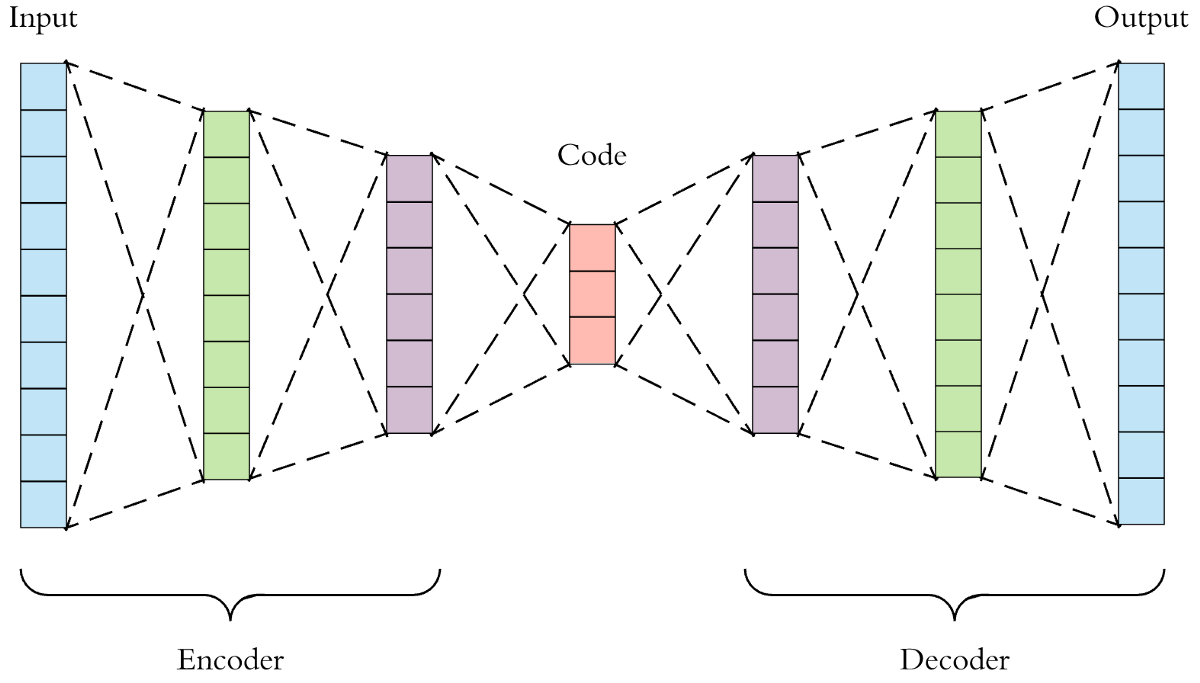

In [5]:
display.Image('../images/autoencoder.png',width=600)

以下是我們分別設計模型的編碼器與解碼器部分，模型設計也是 trident比較特殊之處，因為在原本的 torch 中所有的卷積層都需要指定輸入的通道數( input-channel) ，同時也需要自己指定 padding 需要的量，同時一般建模所常用的卷積 ->正規化 ->活化函數都需要自己一層一層指定或者是自己把它包成自訂模組，在 trident 中不需要層層指定輸入通道數，只需要第一層指定輸入形狀、或是第一次 forward自行偵測輸入形狀、也可以透過shape_infer([input_size]) 就可以自動更新全體的input_filters ，此外padding 也可以替換為 auto_pad 即可自動計算保持原形狀所需的 padding量，同時內建的Conv2d_Block直接讓卷積、正規化、活化函數、 dropout 和添加噪音等功能都集合在一起，這樣開發起來就更方便了。

In [6]:

encoder=Sequential(
    Conv2d_Block((5,5),32,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(128,128,128)
    Conv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,64,64)
    Conv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(32,32,64)
    Conv2d_Block((3,3),128,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False,dropout_rate=0.2),#(16,16,128)
    Conv2d_Block((3,3),128,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(8,8,128)
    Conv2d_Block((3,3),128,strides=1,auto_pad=True,activation='leaky_relu',normalization=None,use_bias=False),#(4,4,128)
    Reshape((-1)), #(2048)
    Dense(256,activation='tanh',use_bias=False,kernel_constraint='unit_norm')
)


decoder=Sequential(
    Dense(128*4*4,activation='tanh',use_bias=False,kernel_constraint='unit_norm'), #(2048))
    BatchNorm(),
    Reshape((4,4,128)), #(4,4,128)
    TransConv2d_Block((3,3),128,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False) ,#((4,4,128))
    TransConv2d_Block((3,3),128,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(8,8,128)
    TransConv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False,dropout_rate=0.2),#(16,16,64)
    TransConv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(32,32,64)
    TransConv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,64,64)
    Conv2d((1,1),3,strides=1,auto_pad=True,activation='tanh',use_bias=False)
)


自動編碼器的模型就只要將編碼器與解碼器連在一起就完成了

In [7]:
autoencoder=Sequential(
    encoder,
    decoder
)

剛才提到了有關於輸入形狀的推斷， trident 中的所有神經網路層都是支援延遲推斷的，這樣的好處是在於不需要逐層設定輸入通道數，只需要做一次(整體模型，也就是最外層)即可

Tensorflow 2.x為了對抗強敵Pytorch，因此從原本的靜態圖跟進變成了動態計算圖。但是一方面又放不下過去企圖與過去兼容，但是新舊技術架構差異太大，所以搞成不上不下。拿一般大眾最為熟知以及喜愛的Keras來說，原本是中立的第三方高階api，但是自從Keras作者被谷歌收編之後，作者已經宣布原本的Keras將停止維護，而且Keras將成為Tensorflow的預設api。但是Keras所有的邏輯都是基於靜態計算圖，所以tensorflow又弄出了tf.keras，而且這兩個keras彼此之間還不相容，也因此氣走了不少使用者。Trident完全是基於動態計算圖的概念設計，也因此很難直接套用Keras的概念，因此我們利用tf.Module重寫了類似於Pytorch的nn.Module，這也就是為何我們可以除了張量方向之外，做到兩個框架的開發代碼一致。Keras中超方便的Model.fit我們也仍然保留，但是若您想要設定較為複雜的訓練流程。 trident 中我重新包裝了 TrainingPlan的容器，在其中已經將訓練過程的這些細節通通都封裝好了，甚至包括多久列印出來進度、多久顯示損失函數變化曲線、多久存檔一次 ... 這些通通都可以很直覺化的設定，而且使用了Fluent Code風格，讓它可以很方便設定以及增加了可讀性與維護性。

In [8]:

model=Model(input_shape=(128,128,3),output=autoencoder)\
    .with_optimizer(optimizer='Ranger',lr=1e-3,betas=(0.9, 0.999),gradient_centralization='all')\
    .with_loss(MSELoss(reduction='mean'),loss_weight=2.0,name='l2 loss')\
    .with_loss(EdgeLoss,loss_weight=0.1,name='edge loss')\
    .with_metric(rmse,name='rmse')\
    .with_regularizer('l2',reg_weight=1e-6)\
    .with_initializer(kaiming_normal)\
    .with_model_save_path('Models/pokemon_ae1_tf.pth')\
    .with_learning_rate_scheduler(CosineLR(frequency=3000,unit='batch',max_lr=1e-3, min_lr=1e-8))\
    .with_callbacks(TileImageCallback(frequency=5,unit='epoch',include_input=True,include_output=True,include_target=False,imshow=True))\
  



model.summary()

l2 loss( output: Tensor[(None,)] , target: Tensor[(None,)] ) -> loss: Tensor[(None,)]  
edge loss( output: Tensor[(None,)] , target: Tensor[(None,)] ) -> loss: Tensor[(None,)]  
rmse( output: Tensor[None] , target: Tensor[None] ) -> output: Tensor[(None,)]  
--------------------------------------------------------------------------------------------------------------------------------
        Layer (type)          Output Shape               Weight                          Bias      Param #   FLOPS #                  
0.0.conv  [Conv2d]            [None, 128, 128, 32]       'weight', [5, 5, 3, 32]                   2,400  19,656,704  
0.0.norm  [BatchNorm]         [None, 128, 128, 32]       'weight', [32]                  'bias', [32]  64  516,096  
0.0  [Conv2d_Block]           [None, 128, 128, 32]                                                 0  0  
0.1.conv  [Conv2d]            [None, 64, 64, 64]         'weight', [3, 3, 32, 64]                  18,432  150,990,848  
0.1.norm  [Bat

Model(
  (_losses): <trident.optims.tensorflow_losses.MSELoss object at 0x000001BFE3F15CC0>
  (_losses): <trident.optims.tensorflow_losses.EdgeLoss object at 0x000001BFE3F15A20>
  (_metrics): <function root_mean_squared_error at 0x000001BFE3B1C0D0>
  (loss_weights): 2.0
  (loss_weights): 0.1
  (_regs): <function l2_reg at 0x000001BFE3AFF158>
)

In [9]:
plan=TrainingPlan()\
    .add_training_item(model)\
    .with_data_loader(data_provider)\
    .repeat_epochs(500)\
    .with_batch_size(32)\
    .print_progress_scheduling(1,unit='epoch')\
    .save_model_scheduling(2,unit='epoch')\
    .display_loss_metric_curve_scheduling(frequency=10,unit='epoch',imshow=True)
    


所以以上TrainingPlan的設定就是
1. 加入TrainingItem (包含了模型、優化器、損失函數、效度指標、權重正則)
2. 指定 data_loader
3. 重複250 epoch
4. 指定大小 
5. 指定學習率變化模式
6. 印出學習進度
7. 指定模型存檔週期
8. 顯示autoencoder 效果輸出圖
9. 指定繪製損失函數與指標變動歷史圖的週期

除了預設的功能外，事實上也可以利用 Callbacks 的機制在關鍵時間點插入自定義工作，這些特性之後也會在介紹，設定完成後，只需要透過start_now()函數即可啟動。

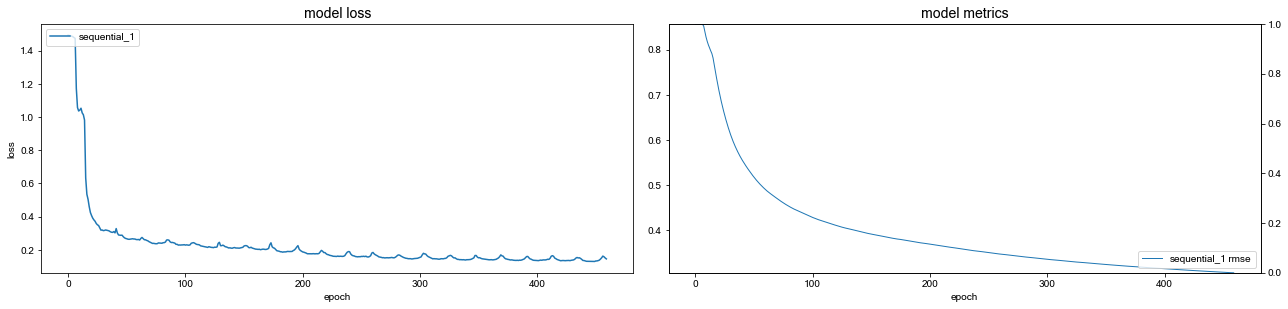

{ l2 loss: 0.131, edge loss: 0.0132, l2_reg_Loss: 0.00899, total_losses: 0.154 }
sequential_1     Step: 31s935ms | Loss: 0.144| rmse: 30.628% | lr: 6.425e-04   ( 461/500 )
{ l2 loss: 0.109, edge loss: 0.0102, l2_reg_Loss: 0.009, total_losses: 0.128 }
sequential_1     Step: 31s961ms | Loss: 0.140| rmse: 30.615% | lr: 5.000e-04   ( 462/500 )
{ l2 loss: 0.111, edge loss: 0.011, l2_reg_Loss: 0.00899, total_losses: 0.131 }
sequential_1     Step: 35s285ms | Loss: 0.136| rmse: 30.600% | lr: 3.575e-04   ( 463/500 )
{ l2 loss: 0.116, edge loss: 0.0127, l2_reg_Loss: 0.00899, total_losses: 0.137 }
sequential_1     Step: 36s416ms | Loss: 0.134| rmse: 30.586% | lr: 2.268e-04   ( 464/500 )
{ l2 loss: 0.122, edge loss: 0.0135, l2_reg_Loss: 0.00899, total_losses: 0.144 }


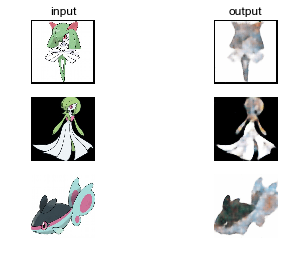

sequential_1     Step: 37s232ms | Loss: 0.132| rmse: 30.571% | lr: 1.188e-04   ( 465/500 )
{ l2 loss: 0.113, edge loss: 0.0116, l2_reg_Loss: 0.00899, total_losses: 0.134 }
sequential_1     Step: 32s427ms | Loss: 0.133| rmse: 30.556% | lr: 4.239e-05   ( 466/500 )
{ l2 loss: 0.116, edge loss: 0.0123, l2_reg_Loss: 0.00899, total_losses: 0.137 }
sequential_1     Step: 32s809ms | Loss: 0.131| rmse: 30.541% | lr: 3.953e-06   ( 467/500 )
{ l2 loss: 0.115, edge loss: 0.0125, l2_reg_Loss: 0.00898, total_losses: 0.136 }
sequential_1     Step: 33s445ms | Loss: 0.132| rmse: 30.526% | lr: 6.667e-06   ( 468/500 )
{ l2 loss: 0.112, edge loss: 0.012, l2_reg_Loss: 0.00898, total_losses: 0.133 }
sequential_1     Step: 31s621ms | Loss: 0.132| rmse: 30.511% | lr: 5.031e-05   ( 469/500 )
{ l2 loss: 0.112, edge loss: 0.012, l2_reg_Loss: 0.00898, total_losses: 0.133 }


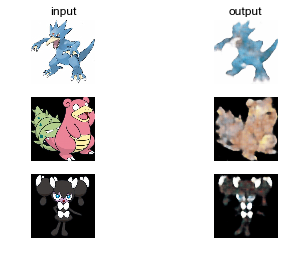

sequential_1     Step: 32s105ms | Loss: 0.133| rmse: 30.496% | lr: 1.313e-04   ( 470/500 )


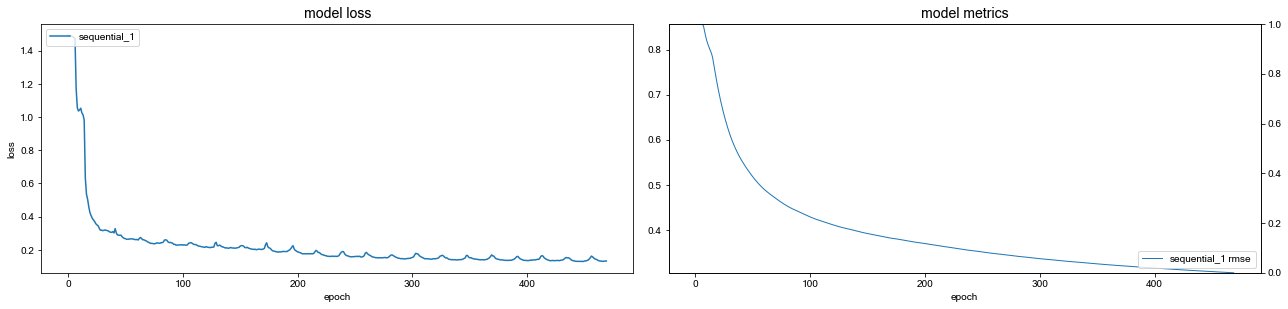

{ l2 loss: 0.101, edge loss: 0.0107, l2_reg_Loss: 0.00898, total_losses: 0.12 }
sequential_1     Step: 33s216ms | Loss: 0.132| rmse: 30.481% | lr: 2.428e-04   ( 471/500 )
{ l2 loss: 0.118, edge loss: 0.0127, l2_reg_Loss: 0.00898, total_losses: 0.14 }
sequential_1     Step: 33s145ms | Loss: 0.131| rmse: 30.467% | lr: 3.757e-04   ( 472/500 )
{ l2 loss: 0.114, edge loss: 0.012, l2_reg_Loss: 0.00898, total_losses: 0.135 }
sequential_1     Step: 32s670ms | Loss: 0.132| rmse: 30.452% | lr: 5.188e-04   ( 473/500 )
{ l2 loss: 0.113, edge loss: 0.0115, l2_reg_Loss: 0.00897, total_losses: 0.133 }
sequential_1     Step: 32s591ms | Loss: 0.135| rmse: 30.438% | lr: 6.605e-04   ( 474/500 )
{ l2 loss: 0.106, edge loss: 0.0116, l2_reg_Loss: 0.00896, total_losses: 0.127 }


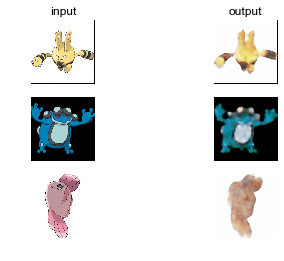

sequential_1     Step: 32s487ms | Loss: 0.137| rmse: 30.424% | lr: 7.888e-04   ( 475/500 )
{ l2 loss: 0.123, edge loss: 0.0121, l2_reg_Loss: 0.00896, total_losses: 0.144 }
sequential_1     Step: 32s979ms | Loss: 0.139| rmse: 30.410% | lr: 8.931e-04   ( 476/500 )
{ l2 loss: 0.114, edge loss: 0.0112, l2_reg_Loss: 0.00896, total_losses: 0.134 }
sequential_1     Step: 38s938ms | Loss: 0.143| rmse: 30.398% | lr: 9.649e-04   ( 477/500 )
{ l2 loss: 0.124, edge loss: 0.0128, l2_reg_Loss: 0.00897, total_losses: 0.146 }
sequential_1     Step: 33s198ms | Loss: 0.152| rmse: 30.386% | lr: 9.981e-04   ( 478/500 )
{ l2 loss: 0.128, edge loss: 0.0133, l2_reg_Loss: 0.00899, total_losses: 0.151 }
sequential_1     Step: 32s773ms | Loss: 0.155| rmse: 30.376% | lr: 9.899e-04   ( 479/500 )
{ l2 loss: 0.136, edge loss: 0.013, l2_reg_Loss: 0.00902, total_losses: 0.158 }


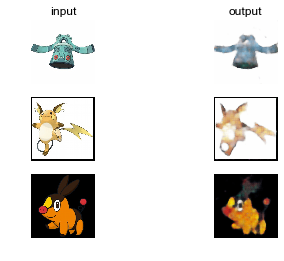

sequential_1     Step: 32s276ms | Loss: 0.156| rmse: 30.367% | lr: 9.411e-04   ( 480/500 )


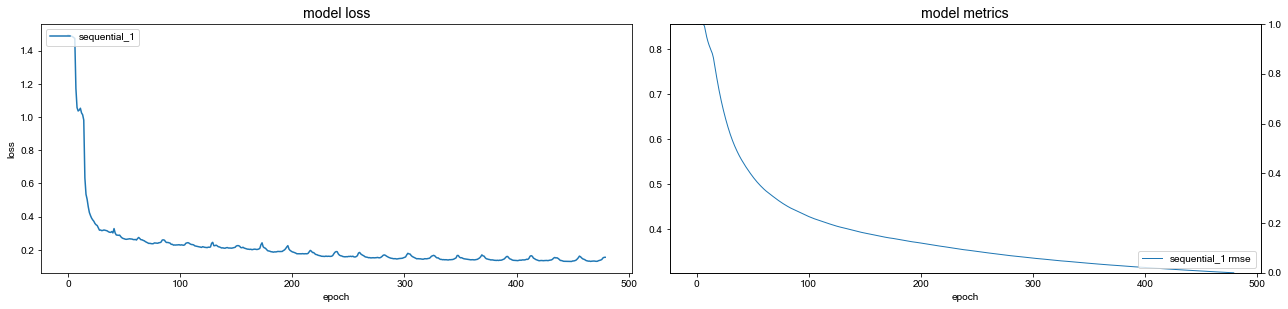

{ l2 loss: 0.137, edge loss: 0.012, l2_reg_Loss: 0.00907, total_losses: 0.158 }
sequential_1     Step: 33s521ms | Loss: 0.150| rmse: 30.358% | lr: 8.558e-04   ( 481/500 )
{ l2 loss: 0.125, edge loss: 0.0112, l2_reg_Loss: 0.0091, total_losses: 0.145 }
sequential_1     Step: 32s714ms | Loss: 0.143| rmse: 30.346% | lr: 7.409e-04   ( 482/500 )
{ l2 loss: 0.117, edge loss: 0.0125, l2_reg_Loss: 0.00911, total_losses: 0.139 }
sequential_1     Step: 33s375ms | Loss: 0.141| rmse: 30.334% | lr: 6.060e-04   ( 483/500 )
{ l2 loss: 0.106, edge loss: 0.0109, l2_reg_Loss: 0.00911, total_losses: 0.126 }
sequential_1     Step: 33s160ms | Loss: 0.136| rmse: 30.321% | lr: 4.623e-04   ( 484/500 )
{ l2 loss: 0.106, edge loss: 0.0111, l2_reg_Loss: 0.00911, total_losses: 0.127 }


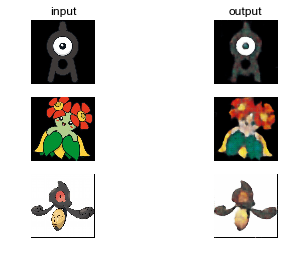

sequential_1     Step: 33s305ms | Loss: 0.132| rmse: 30.308% | lr: 3.218e-04   ( 485/500 )
{ l2 loss: 0.104, edge loss: 0.0117, l2_reg_Loss: 0.0091, total_losses: 0.125 }
sequential_1     Step: 37s38ms  | Loss: 0.130| rmse: 30.294% | lr: 1.960e-04   ( 486/500 )
{ l2 loss: 0.107, edge loss: 0.0108, l2_reg_Loss: 0.0091, total_losses: 0.127 }
sequential_1     Step: 33s491ms | Loss: 0.130| rmse: 30.280% | lr: 9.550e-05   ( 487/500 )
{ l2 loss: 0.11, edge loss: 0.0125, l2_reg_Loss: 0.0091, total_losses: 0.131 }
sequential_1     Step: 33s80ms  | Loss: 0.129| rmse: 30.266% | lr: 2.851e-05   ( 488/500 )
{ l2 loss: 0.109, edge loss: 0.0117, l2_reg_Loss: 0.0091, total_losses: 0.13 }
sequential_1     Step: 34s501ms | Loss: 0.129| rmse: 30.252% | lr: 6.415e-07   ( 489/500 )
{ l2 loss: 0.107, edge loss: 0.0106, l2_reg_Loss: 0.0091, total_losses: 0.127 }


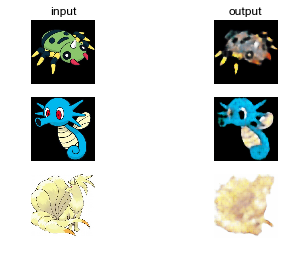

sequential_1     Step: 33s208ms | Loss: 0.129| rmse: 30.238% | lr: 1.419e-05   ( 490/500 )


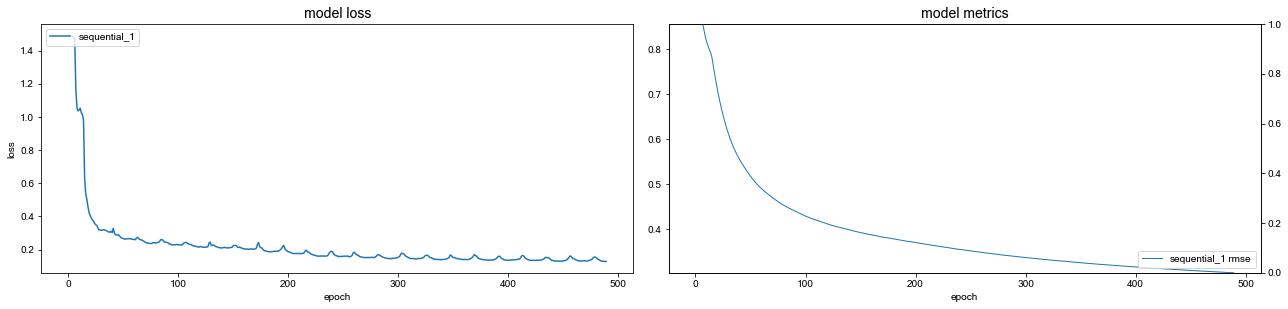

{ l2 loss: 0.1, edge loss: 0.0102, l2_reg_Loss: 0.0091, total_losses: 0.12 }
sequential_1     Step: 33s274ms | Loss: 0.128| rmse: 30.224% | lr: 6.805e-05   ( 491/500 )
{ l2 loss: 0.106, edge loss: 0.0112, l2_reg_Loss: 0.00909, total_losses: 0.126 }
sequential_1     Step: 42s230ms | Loss: 0.128| rmse: 30.210% | lr: 1.577e-04   ( 492/500 )
{ l2 loss: 0.118, edge loss: 0.0126, l2_reg_Loss: 0.00909, total_losses: 0.139 }
sequential_1     Step: 31s961ms | Loss: 0.127| rmse: 30.196% | lr: 2.758e-04   ( 493/500 )
{ l2 loss: 0.111, edge loss: 0.0116, l2_reg_Loss: 0.00909, total_losses: 0.131 }
sequential_1     Step: 44s76ms  | Loss: 0.128| rmse: 30.183% | lr: 4.125e-04   ( 494/500 )
{ l2 loss: 0.0991, edge loss: 0.0102, l2_reg_Loss: 0.00908, total_losses: 0.118 }


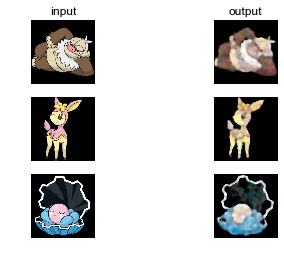

sequential_1     Step: 39s450ms | Loss: 0.127| rmse: 30.169% | lr: 5.564e-04   ( 495/500 )
{ l2 loss: 0.108, edge loss: 0.0108, l2_reg_Loss: 0.00908, total_losses: 0.128 }
sequential_1     Step: 32s768ms | Loss: 0.129| rmse: 30.156% | lr: 6.957e-04   ( 496/500 )
{ l2 loss: 0.106, edge loss: 0.0109, l2_reg_Loss: 0.00907, total_losses: 0.126 }
sequential_1     Step: 32s536ms | Loss: 0.132| rmse: 30.143% | lr: 8.187e-04   ( 497/500 )
{ l2 loss: 0.108, edge loss: 0.0101, l2_reg_Loss: 0.00907, total_losses: 0.128 }
sequential_1     Step: 36s132ms | Loss: 0.136| rmse: 30.130% | lr: 9.153e-04   ( 498/500 )
{ l2 loss: 0.122, edge loss: 0.0122, l2_reg_Loss: 0.00907, total_losses: 0.143 }
sequential_1     Step: 36s992ms | Loss: 0.142| rmse: 30.119% | lr: 9.774e-04   ( 499/500 )
{ l2 loss: 0.125, edge loss: 0.0116, l2_reg_Loss: 0.00908, total_losses: 0.146 }


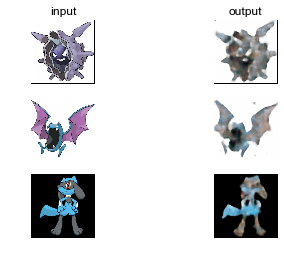

sequential_1     Step: 47s527ms | Loss: 0.146| rmse: 30.108% | lr: 1.000e-03   ( 500/500 )


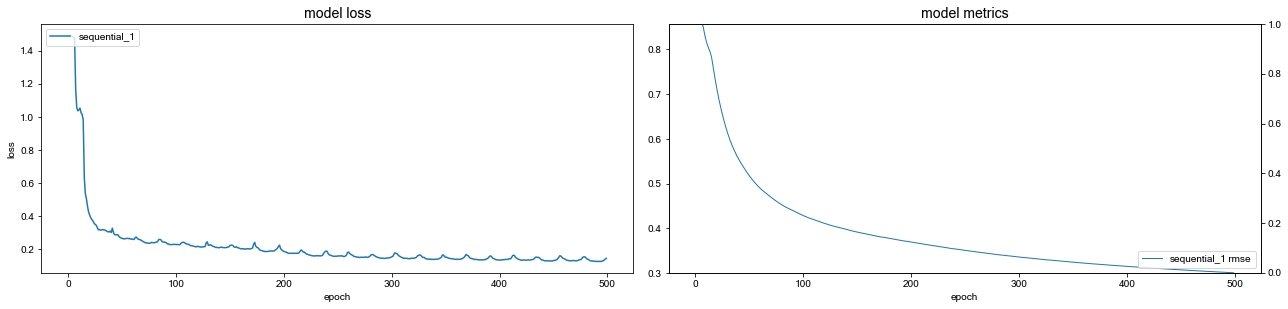

In [10]:
plan.start_now()

以下是我跑了 500 epoch 的成果，是不是可以看到從雜訊到模糊，一直到越來越清晰的過程呢，只要訓練的時間夠久就能夠越來越清晰。如果您手邊沒有 gpu  ，建議可以透過有免費gpu的google 的colab 來執行。

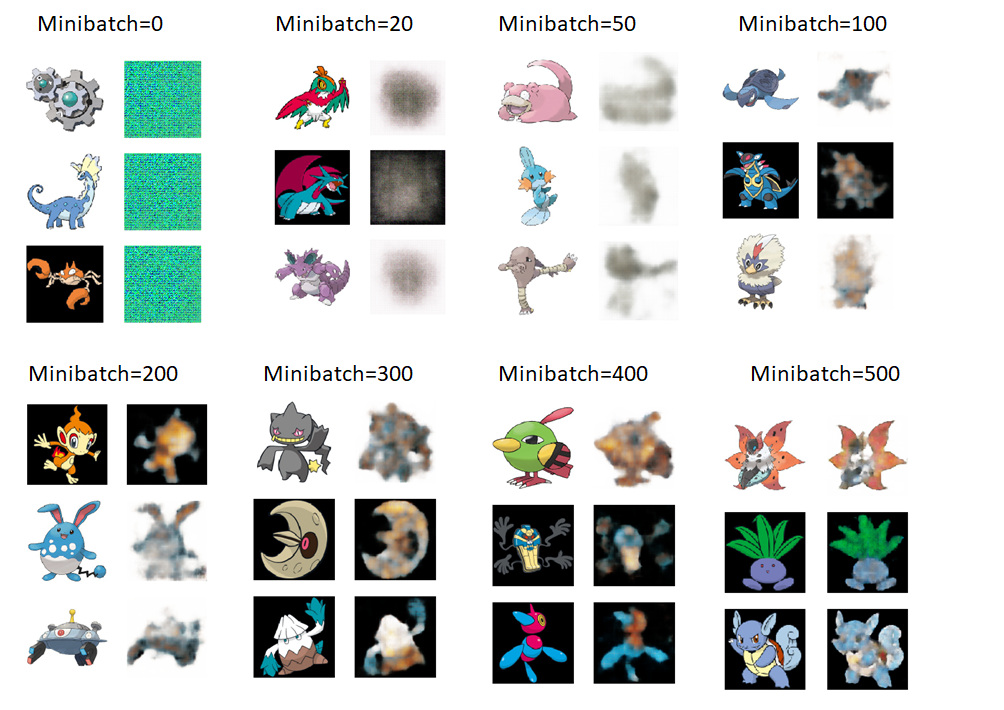

In [11]:
display.Image('../images/pokemon_training.png',width=800)

## 表徵學習 

可能會有人覺得奇怪，自編碼器重建圖像就算訓練好了，到底是有甚麼作用？其實，對我們有用的並不是整個自編碼器，我們要的其實是前半段的編碼器部分。編碼器的工作是將圖片編碼成長度為 128 向量(為了避免使用到全連接層，所以實際上是 (128,1,1) 的形狀)，等於是將圖片抽出它的關鍵特徵，而這些特徵既然可以用來還原回圖像細節，這表示它必定包含了這個圖片中的關鍵訊息。這也是深度學習中表徵學習(representation learning)中最常見的手法。而這些特徵向量就可以幫助我們評估圖片中的相似性，也就是可以做到視覺搜索的效果。

我們首先利用data_provider逐一取出所有圖片，依序透過編碼器(autoencoder[0])產生特徵向量，並將1444 張圖片的特徵向量整併成尺寸為 (1444,128) 的向量

In [12]:
data_provider2=T.load_examples_data('pokemon')

data_provider2.traindata.is_shuffle=False
data_provider2.traindata.batch_size=1
#設定模型輸入資料的前處理
data_provider2.image_transform_funcs=[
    Resize(output_size=(128,128)),
    Normalize(127.5,127.5)]

archive file is already existing, donnot need download again.
extraction is finished, donnot need extract again.
C:/Users/Allan/.trident/datasets/examples_pokemon/pokemon
get pokemon images :1444


In [13]:
#我們要取出表徵只需要編碼器
encoder_model=Model(input_shape=(128,128,3),output=encoder)

In [14]:
features=[]
for i, (img,) in enumerate(tqdm(data_provider2)):
    if i<len(data_provider2.traindata):
        #img=unpack_singleton(img)
        encoder_output=encoder_model(img)
        features.append( l2_normalize(encoder_output[0]))
    else:
        break


features=np.stack(features,0)
print(features.shape)

image_data=data_provider2.traindata.data.items

100%|██████████████████████████████████████████████████████████████████████████████| 1444/1444 [01:24<00:00, 17.04it/s]

(1444, 256)


我們如果想要看一下特徵向量整體的效果可透過傳說中的降維神器 t-SNE ，將特徵向量降為並且視覺化。

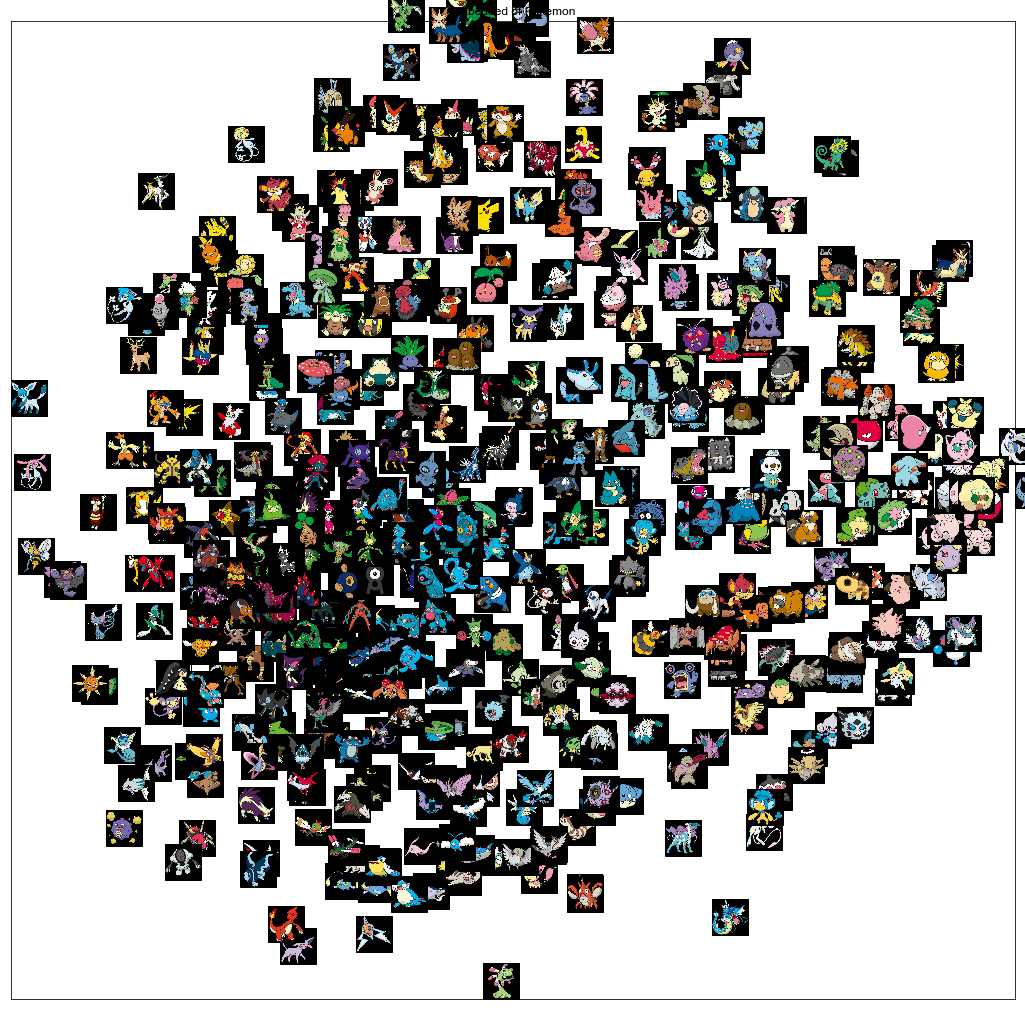

In [15]:
from matplotlib import offsetbox
from sklearn import manifold
import PIL
from PIL import Image as Image

resize_fn=Resize((36,36),True)

def plot_embedding(X, image_data, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    fig =plt.figure(figsize=(18,18))
    ax = plt.subplot(111)

    if hasattr(offsetbox, 'AnnotationBbox'):
        # 需要matplotlib 版本> 1.0才支援顯示圖片功能
        #shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            #將向量轉圖片，且將圖片縮小至32*32
            img=resize_fn(image2array(image_data[i])).astype(np.uint8)
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(img),X[i],pad=0, box_alignment=(0, 0))
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

#利用 t-SNE  降維
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)#利用t-sne將128特徵向量降維至2
X_tsne = tsne.fit_transform(features[:500,:])#為了避免圖片太密我只用了前500來處理

plot_embedding(X_tsne, image_data,"Embedded of Pokemon")#繪製圖像散布圖

看起來頗壯觀，仔細看的確位置比較接近的都有向是姿態、顏色、類型的相似，那麼我們該如何達到視覺搜索的效果呢?

## 寶可夢的相似性搜索 

特徵向量因為在學習過程中被多次正規化，因此計算歐幾里得距離是沒有意義的，所以一般是用 cosine距離，在這種逐一比較 cosine距離的場景下，若是一個一個比實在太累了， trident 內建了一次產生各成員 cosine距離的函數element_cosine_distance，所以可以一次性的比較，然後取出距離最大者( cosine距離跟其他距離不一樣，越相似者 cosine距離越大)。

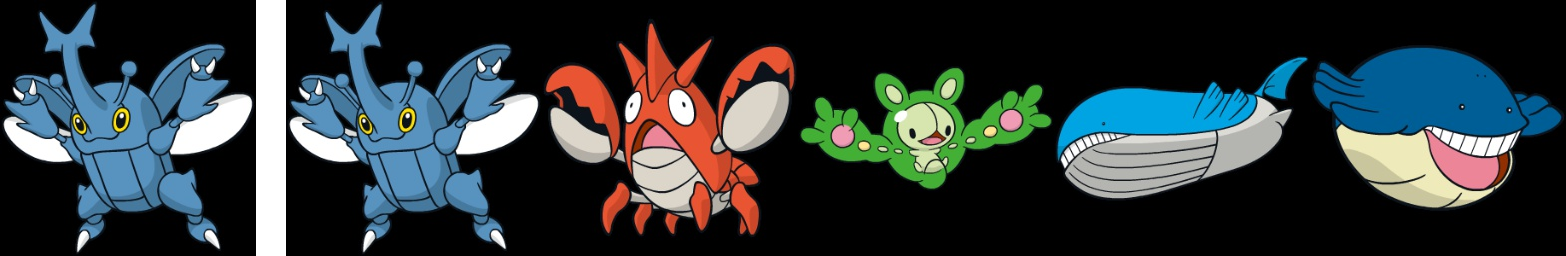

In [16]:


def find_similar_pokemon(idx):
    similarity_list=[]
    result=to_numpy(element_cosine_distance(to_tensor(features[idx:idx+1,:]),to_tensor(features)))  #element_cosine_distance逐成員計算Cosine距離

    nearest5=np.argsort(result[0])[::-1][:5]  #找出前 5個Cosine距離最高者(Cosine距離是越高越像)
    similarity_list=[image2array(image_data[idx])] #放入原圖
    similarity_list.append(np.ones_like(similarity_list[0])[:,:30,:]*255) # 加入白色分隔線
    [similarity_list.append(image2array(image_data[_idx])) for _idx in nearest5] #放入前 5名圖 
    merge_img=np.concatenate(similarity_list,axis=1) #沿著寬(axis=1)疊合
    display.display(array2image(merge_img)) #顯示結果



idx=128 #抽取一隻寶可夢
find_similar_pokemon(idx)

我們當然也可以把傳入的索引值透過隨機的方式來指派，這樣我們就可以觀察到更多樣的搜索結果

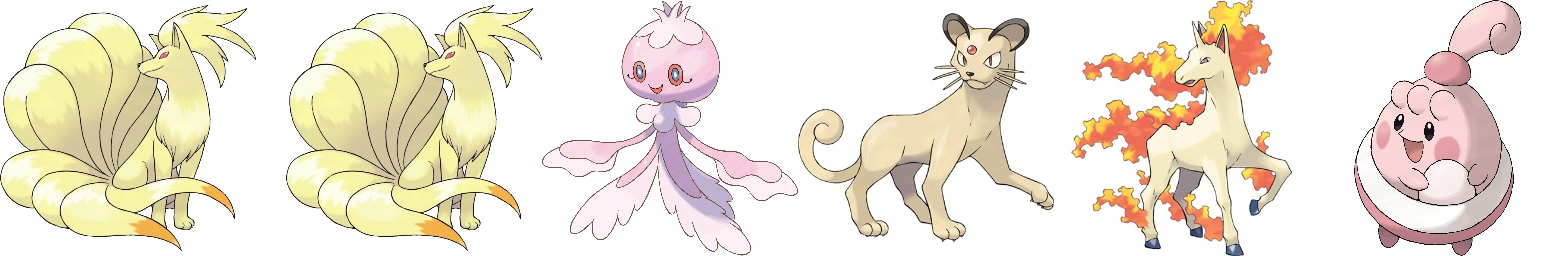

In [17]:
import random
find_similar_pokemon(random.choice(range(1444)))

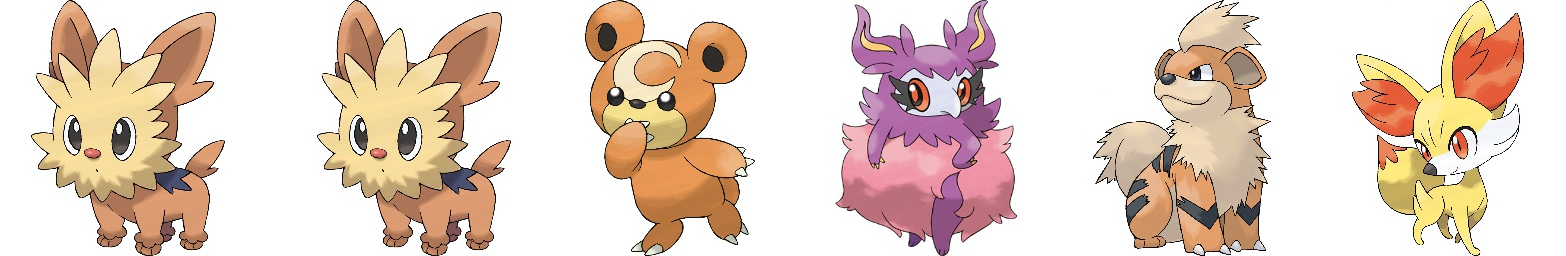

In [18]:
find_similar_pokemon(random.choice(range(1444)))

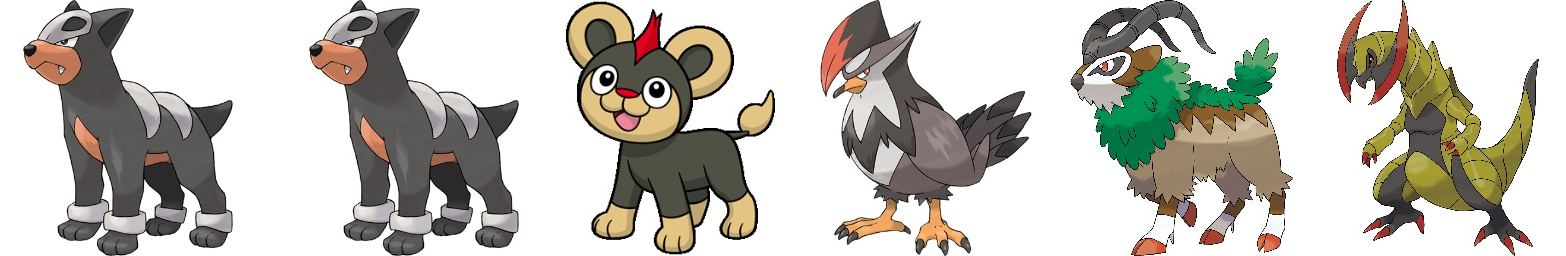

In [19]:
find_similar_pokemon(random.choice(range(1444)))